In [1]:
# Import libraries

%pylab inline

import numpy as np
import scipy.io
from astropy.io import ascii
from astropy.table import Table, Column
from astropy.io import fits
import matplotlib.pyplot as plt
import glob
import pickle
import time
from scipy.stats import beta

Populating the interactive namespace from numpy and matplotlib


In [2]:
# First read the convolved photometry
dir_conv = '/Users/jmartine/science/em_alg/' # Directory where convolved fluxes are located
idl_dict1=scipy.io.readsav(dir_conv+'all_conv.save')
del idl_dict1['model_str']
del idl_dict1['dir_conv']
nombres = np.arange(20071)

/Users/jmartine/anaconda/lib/python2.7/site-packages/scipy/io/idl.py:418: UserWarning: Skipping SYSTEM_VARIABLE record
  warnings.warn("Skipping SYSTEM_VARIABLE record")


In [3]:
# Read model parameters and order them
idl_dict = scipy.io.readsav('/Users/jmartine/science/em_alg/model_params.save')
age1 = idl_dict['age'][idl_dict['incli']==87.1300]
mass1 = idl_dict['massc'][idl_dict['incli']==87.1300]
ltot1 = idl_dict['ltot'][idl_dict['incli']==87.1300]
#id1 = idl_dict['id'][idl_dict['incli']==87.1300]
it1 = np.argsort(age1)
it2 = np.argsort(mass1)
age2 = np.sort(age1)
mass2 = np.sort(mass1)
ltot2 = np.sort(ltot1)
age3 = age1[it1]
mass3 = mass1[it1]
ltot3 = ltot1[it1]
id3 = nombres[it1]

In [4]:
# Read extinction law
ext_law = ascii.read("extinction_law.ascii")    # This is the extinction law (Fischera et al. 2005)
wavita = ext_law['col1']
opacita = ext_law['col2']

In [5]:
# Function to apply extinction correction
def ext_law(wavelengths_filters, Av, wavita, opacita):
    A_lambda = Av * (opacita/211.4)
    A_lambda_waves = np.interp(wavelengths_filters,wavita,A_lambda)
    corr_factor = 10.0**(-0.4*A_lambda_waves)   # This is the array of correction factors to be applied to each band
    return corr_factor

In [6]:
# Prior for the inclination angle
# This prior is based on a randon orientation of the disks. In that case, the 
# angle with respect to the line of sight is distributed as the cosine
# of the angle.

def prior_angle(index):
    prior = np.array([  6.50851226e+00,   2.97655246e+00,   1.66647382e+00,   9.58111152e-01,\
             5.37746335e-01,   2.82934901e-01,   1.33018844e-01,   5.08983303e-02, \
             1.26255358e-02,   7.12009421e-04])
    #prior = np.array([7.12009421e-04,5.08983303e-02,2.82934901e-01,9.58111152e-01,2.97655246e+00,\
    #                 6.50851226e+00,1.66647382e+00,5.37746335e-01,1.33018844e-01,1.26255358e-02])
    prior_norm = prior/sum(prior)
    return prior_norm[index]


# Prior for age
# Samples age in log space. Normal distribution.
def prior_age(log_age,mean,sigma):
    prior = scipy.stats.norm.pdf(log_age,loc=mean,scale=sigma)
    return prior


# Prior for Av
# Normal distribution in log space
def prior_Av(log_Av,mean,sigma):
    prior = scipy.stats.norm.pdf(log_Av,loc=mean,scale=sigma)
    return prior


In [7]:
# The fitness function is the posterior probability distribution, that we attempt to maximixe

def fitness(individual, obs_res, obs_unres, obs_res_err, obs_unres_err):
    
    
    filter_names = ['model_str_2j','model_str_2h','model_str_2k','model_str_i1',
                'model_str_i2','model_str_i3','model_str_i4','model_str_m1']
    filter_wavelengths = np.array([1.235,1.651,2.159,3.550,4.493,5.731,7.872,23.68])
    
    list_filters = filter_names
    
    # Get number of sources
    n_sources = len(individual)
    # Get number of bands in which sources are resolved
    n_bands_resolved = len(obs_res)
    #n_data = len(model_fluxes[0])
    
    model_fluxes_all = []   # Array that will be filled with the model fluxes for all sources at all wavelengths
    prior_incl = 1.0
    prior_t = 1.0
    prior_obs = 1.0
    
    for i in np.arange(n_sources):
        model_fluxes = []
        for filter in list_filters:
            model_fluxes.append(idl_dict1[filter]['fluxes'][0][49][10*individual[i][0]+individual[i][1]])
            
        corr_ext = ext_law(filter_wavelengths,individual[i][2],wavita,opacita)   # Extinction correction
        model_fluxes = corr_ext*model_fluxes/(individual[i][3]**2)
        model_fluxes_all.append(model_fluxes)
        prior_incl *= prior_angle(individual[i][1]) # Prior on inclination
        age = idl_dict['age'][10.0*individual[i][0]+individual[i][1]]
        prior_t *= prior_age(np.log10(age),5.5,1.0)
        prior_obs *= prior_Av(np.log10(individual[i][2]),1.3,0.8)
        
    # Start calculation of likelihood
    
    # Remove no-data points
    zeros_index = np.array(np.where(obs_unres == 0.0))
    obs_unres = np.delete(obs_unres,zeros_index)
    obs_unres_err = np.delete(obs_unres_err,zeros_index)
    for source in np.arange(n_sources): model_fluxes_all[source] = np.delete(model_fluxes_all[source],n_bands_resolved+zeros_index)
    
    for source in np.arange(n_sources):
        zeros_index = np.array(np.where(obs_res[source] == 0.0))
        obs_res[source] = np.delete(obs_res[source],zeros_index)
        obs_res_err[source] = np.delete(obs_res_err[source],zeros_index)
        model_fluxes_all[source] = np.delete(model_fluxes_all[source],zeros_index)
    
    chi_squared = 0 
    
    # Calculate chi squared for resolved bands
    
    for source in np.arange(n_sources):
        
        # Get upper limits
        ind_upper_res = np.where(obs_res_err[source] == -1)
        
        for i in np.arange(len(model_fluxes_all[source][ind_upper_res])):
            if (model_fluxes_all[source][ind_upper_res][i] > obs_res[source][ind_upper_res][i]):
                chi_squared += float('Inf')
                continue            
        
        # Updated number of resolved datapoints
        n_data_res = len(obs_res[source])
    
        # Unbiased flux in log space (since we are fitting in logarithmic space, see Robitaille et al. 2007)
        #print 'aaaa',shape(obs_res[source])
        #print 'bbbb',shape(obs_res_err[source])
        log_obs_flux = np.log10(obs_res[source]) \
        -0.5*(1.0/np.log(10.))*(1.0/(obs_res[source]**2.0)) \
        *obs_res_err[source]*obs_res_err[source]
        
        # Unbiased variances in log space (since we are fitting in logarithmic space, see Robitaille et al. 2007)
        log_obs_var2 = (((1.0/np.log(10.))*(1.0/obs_res[source]))**2.0) \
        *obs_res_err[source]*obs_res_err[source] 
    
        # Model flux in log space
        log_mod_flux = np.log10(model_fluxes_all[source][0:n_data_res]) 
    
        # Reduced chi^2
        #print source, n_data_res, (1.0/n_data_res)*sum(((log_obs_flux - log_mod_flux)*(log_obs_flux - log_mod_flux)) \
                                            #/(2.0*weight*(log_obs_var2)))
        chi_squared += (1.0/n_data_res)*sum(((log_obs_flux - log_mod_flux)*(log_obs_flux - log_mod_flux)) \
                                            /(2.0*(log_obs_var2)))
    
    # Calculate chi squared for unresolved bands
    # Get upper limits
    ind_upper_unres = np.where(obs_unres_err == -1)
    
    # Likelihood is 0 if model flux at upper limit band is larger than the measured one.
    mod_flux_upper = 0.0
    for source in np.arange(n_sources): 
        mod_flux_upper += model_fluxes_all[source][n_data_res:][ind_upper_unres]
    if (mod_flux_upper > obs_unres_err[ind_upper_unres]):
        chi_squared += float('Inf')
    
    # Updated number of unresolved datapoints
    n_data_unres = len(obs_unres)
    
    # Unbiased flux in log space (since we are fitting in logarithmic space, see Robitaille et al. 2007)
    log_obs_flux = np.log10(obs_unres)-0.5*(1.0/np.log(10.)) \
    *(1.0/(obs_unres**2.0))*obs_unres_err*obs_unres_err
        
    # Unbiased variances in log space (since we are fitting in logarithmic space, see Robitaille et al. 2007)
    log_obs_var2 = (((1.0/np.log(10.))*(1.0/obs_unres))**2.0) \
    *obs_unres_err*obs_unres_err 
    
    # Model flux in log space
    mod_flux = np.zeros(n_data_unres)
    for source in np.arange(n_sources): 
        mod_flux += model_fluxes_all[source][n_data_res:]
    log_mod_flux = np.log10(mod_flux)
    
    
    # Reduced chi^2
    #print 'unres', n_data_unres, (1.0/n_data_unres)*sum(((log_obs_flux - log_mod_flux)*(log_obs_flux - log_mod_flux)) \
                                        #/(2.0*weight*(log_obs_var2)))
    chi_squared += (1.0/n_data_unres)*sum(((log_obs_flux - log_mod_flux)*(log_obs_flux - log_mod_flux)) \
                                        /(2.0*(log_obs_var2)))
            
    # Likelihood probability (assuming Gaussian errors). Note that the chi squared value is the sum
    # of both resolved and unresolved bands
    if (np.isfinite(chi_squared) == False):
        chi_squared = 1E9
    
    #likelihood_dict = {'chi2':chi_squared, 'likelihood':likelihood}
    
    #print 'chisq_tot', chi_squared
    #print 'prob_tot', likelihood
    
    
    # Log Posterior.
    #log_post = np.log(prior_incl*prior_t*prior_obs*likelihood)
    chi2_post = chi_squared - (np.log(prior_t)+np.log(prior_incl)+np.log(prior_obs))
    
    
    return chi2_post
    

In [34]:
#g_0 = [[17052, 2, 19.28, 3.6],[17619, 7, 2.43, 3.6],[6863, 2, 44.43, 3.6]]
#g_0 = [[8381, 9, 36.653799793746522, 2.590977732950447], [5460, 9, 31.473867497057729, 2.78232499652156], 
       #[13344, 3, 0.1607042728981285, 2.7771643832123556], [11689, 9, 15.664164542248983, 2.7231055464539633],
       #[7440, 6, 15.40562865356298, 2.781837401818737]]
#print fitness(g_0,obs_res, obs_unres, obs_res_err, obs_unres_err)

In [94]:
# Genetic Algorithm
# ==================

# Function to generate individuals (each individual is a set of model parameters)
def individual(n,sigma_av,mean_av,dist,dist_range):
    # Create set of parameters
    params = []
    for i in arange(n):
        params.append([random.randint(0,20071),random.randint(0,10),10.0**(sigma_av*random.randn()+mean_av),
            random.uniform(10.0**(log10(dist)-dist_range),10.0**(log10(dist)+dist_range))])
    return params

# Function to generate a population
def population(count,n,sigma_av,mean_av,dist,dist_range):
    # Create population of individuals
    return [ individual(n,sigma_av,mean_av,dist,dist_range) for x in xrange(count) ]

# Function to evaluate the average fitness of a population
def grade(pop,obs_res, obs_unres, obs_res_err, obs_unres_err):
    summed = sum(fitness(x,obs_res, obs_unres, obs_res_err, obs_unres_err) for x in pop)
    return summed / len(pop)


In [95]:
for i in arange(1000):
    atos = individual(1,0.8,1.3,0.6,0.02)
    print atos
    print idl_dict1['model_str_i1']['fluxes'][0][49][10*atos[0][0]+atos[0][1]]

[[10387, 5, 1.8353078886637717, 0.5950169210897385]]
1.2226
[[7724, 0, 19.84218486371322, 0.5787219974386832]]
547270.0
[[14198, 1, 52.95075171974796, 0.6049528709571159]]
7209.3
[[2017, 2, 654.410778300011, 0.5988771459591434]]
3591.4
[[8967, 4, 41.597109989900005, 0.625499524896592]]
1.1304e+06
[[2527, 2, 4.719390375835171, 0.5879511704210115]]
1.2471
[[14930, 6, 1.4366234277878989, 0.6095605512658266]]
12.012
[[9145, 4, 29.01015264110306, 0.6195125956349105]]
557.04
[[7778, 5, 0.26720672692050645, 0.6188239666323392]]
1.4537
[[15945, 5, 26.320344525395488, 0.5798947765920716]]
231440.0
[[15862, 4, 11.292251247704755, 0.6246915066199863]]
11.457
[[6253, 9, 24.79330211421164, 0.6114320438692221]]
1.892e+06
[[8889, 0, 5.749218742609256, 0.586082050943763]]
622170.0
[[16152, 1, 10.960977346141544, 0.5787268432974151]]
2068.0
[[16950, 9, 1347.9271970335342, 0.6057977499425582]]
0.63726
[[13058, 1, 192.78190039660515, 0.5804558082437518]]
300870.0
[[8959, 3, 8.6272235811903, 0.58923347790

In [35]:
for i in arange(100):
    indv = individual(3,0.8,1.3,3.6,0.02)
    print fitness(indv, obs_res, obs_unres, obs_res_err, obs_unres_err)

/Users/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IndexError: index 2 is out of bounds for axis 0 with size 2

In [98]:
def evolve(pop,obs_res, obs_unres, obs_res_err, 
           obs_unres_err,retain=0.4, random_select=0.05, mutate=0.01):
    
    # First select best fitted individuals to be parents
    graded = [ (fitness(x, obs_res, obs_unres, obs_res_err, obs_unres_err), x) for x in pop]
    graded = [ x[1] for x in sorted(graded)]
    retain_length = int(len(graded)*retain)
    parents = graded[:retain_length]
    
    # Now randomly add other individuals to promote genetic diversity
    for individual in graded[retain_length:]:
        if random_select > np.random.random():
            parents.append(individual)
            
    # mutate some individuals
    for individual in parents:
        if mutate > np.random.random():
            for source in individual:
                source[0] = random.randint(0,20071)
        if mutate > np.random.random():
            for source in individual:
                source[2] = 10.0**(log10(source[2])+0.5*np.random.randn())
                
    # crossover parents to create children
    parents_length = len(parents)
    desired_length = len(pop) - parents_length
    children = []

    while len(children) < desired_length:
    #for i in arange(100):
        male = randint(0, parents_length-1)
        female = randint(0, parents_length-1)
        if male != female:
            male = parents[male]
            female = parents[female]
            #child = [[male[0][0],male[0][1],female[0][2],female[0][3]], 
            #         [male[1][0],male[1][1],female[1][2],female[1][3]], 
            #         [male[2][0],male[2][1],female[2][2],female[2][3]]
            child = [[male[i][0],male[i][1],male[i][2],male[i][3]] for i in arange(len(male))]
            children.append(child)
    
    parents.extend(children)
    return parents

In [99]:
# Read IDs and distances
data = ascii.read("/Users/jmartine/science/data/clusters_morales/all-distances.txt")
id_list = np.array(data['recno'])
dist_list = np.array(data['D'])
errdist_list = np.array(data['eD'])

print dist_list

[  5.9    3.54   2.88   3.59   1.28   1.3    4.97   0.     3.81   2.7
   3.47   3.81   4.13   3.73   2.73   2.63   3.59   3.8    3.59  13.8
   2.15   3.88   2.09   2.72   4.07   3.74   1.8    1.8    1.99   1.8
  11.84   4.71   6.05   6.05   1.27   3.1    6.38   5.93   3.09   4.64
   4.62   7.08   7.33   7.07   7.07   7.01   3.14  11.35   0.56   3.58
   3.84   2.96   3.61   3.72   1.88   1.88   2.48   8.39   5.19  11.2
   5.93   5.91   4.76   9.76   1.92   2.16   2.5    5.22   6.01   7.  ]


aaaaa 360
(1, 1)
ddddd [ 8.67000008  6.82000017  5.44000006  4.55999994         nan]
cccccc [ 0.09562067  0.33616145  0.76682755  0.96174787         nan]
[[ 0.01369478  0.03046399  1.82870364]
 [ 0.0136946   0.03046336  1.48778903]]
[  95.62067409  336.16145033  766.82755258  961.74786667           nan]
[[-1.         -1.          0.27430555]
 [-1.         -1.          0.22316836]]
0
Time =  1.8165  seconds
[[4332, 0, 38.31603355768898, 6.163739231210766], [18454, 1, 74.0159132379498, 5.838558522084853]]
aaaaa 1062
(1, 1)
ddddd [ 9.88000011  9.26000023  8.65999985  8.21000004         nan]
cccccc [ 0.03137268  0.03552614  0.03950917  0.03334735         nan]
[[  1.37279761   6.15802383  10.76319313]
 [  3.29007721   7.49965477  12.89260864]
 [  0.03844284          nan   0.19658601]]

/Users/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: RuntimeWarning: divide by zero encountered in log10



[ 31.37267924  35.52614464  39.50916667  33.34734999          nan]
[[ 0.20591965  0.92370361  1.61447906]
 [ 0.49351159  1.12494826  1.93389142]
 [ 0.00576643         nan  0.0294879 ]]
0


KeyboardInterrupt: 

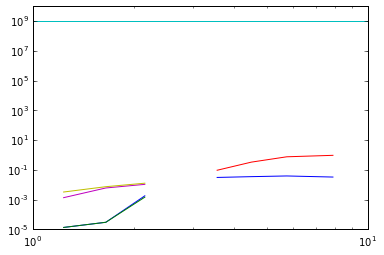

In [106]:
# Read data of observed clusters (from Esteban Morales)
hdulist = fits.open('/Users/jmartine/science/data/clusters_morales/r08-objects.fits')
tbdata = hdulist[1].data

hdulist1 = fits.open('/Users/jmartine/science/data/clusters_morales/ukidss-sources.fits')
tbdata1 = hdulist1[1].data


for i in arange(len(id_list)):
    id = id_list[i]  # ID of the source
    print id
    id_ind = np.array(where(tbdata['recno'] == id))[0][0]

    mags_spitzer = np.array([tbdata[id_ind]['__3_6_G'],tbdata[id_ind]['__4_5_'],tbdata[id_ind]['__5_8_G'],tbdata[id_ind]['__8_0_'],tbdata[id_ind]['__24_']])
    zero_points = np.array([280.9, 179.7,115.0,64.13,7.14])
    flux_spitzer =  zero_points*10.0**(-mags_spitzer/2.5)

    ind_id1 = where(tbdata1['r08_id'] == id)

    mags_ukidss = np.array([tbdata1[ind_id1]['mag_j'],tbdata1[ind_id1]['mag_h'],tbdata1[ind_id1]['mag_k']])
    err_ukidss = np.array([tbdata1[ind_id1]['emag_j'],tbdata1[ind_id1]['emag_h'],tbdata1[ind_id1]['emag_k']])

    q_flags = np.empty_like(mags_ukidss)
    q_flags[0,:] = tbdata1['qflag_j'][ind_id1]
    q_flags[1,:] = tbdata1['qflag_h'][ind_id1]
    q_flags[2,:] = tbdata1['qflag_k'][ind_id1]

    up_flags = np.empty_like(mags_ukidss)
    up_flags[0,:] = tbdata1['up_j'][ind_id1]
    up_flags[1,:] = tbdata1['up_h'][ind_id1]
    up_flags[2,:] = tbdata1['up_k'][ind_id1]

    upper = where(up_flags == 1)
    bad = where(q_flags != 0)

    flux_ukidss = np.empty_like(mags_ukidss)
    error_ukidss = np.empty_like(err_ukidss)
    zero_points = np.array([1594.,1024.,666.7])
    flux_ukidss[0,:] = zero_points[0]*10**(-mags_ukidss[0,:]/2.5)
    flux_ukidss[1,:] = zero_points[1]*10**(-mags_ukidss[1,:]/2.5)
    flux_ukidss[2,:] = zero_points[2]*10**(-mags_ukidss[2,:]/2.5)

    flux_ukidss[bad] = 'nan'  # Get rid of bad measurements

    error_ukidss[0,:] = zero_points[0]*10**(-(mags_ukidss[0,:]-err_ukidss[0,:])/2.5)
    error_ukidss[1,:] = zero_points[1]*10**(-(mags_ukidss[1,:]-err_ukidss[1,:])/2.5)
    error_ukidss[2,:] = zero_points[2]*10**(-(mags_ukidss[2,:]-err_ukidss[2,:])/2.5)


    filter_names = ['model_str_2j','model_str_2h','model_str_2k','model_str_i1',
                'model_str_i2','model_str_i3','model_str_i4','model_str_m1']
    filter_wavelengths = np.array([1.235,1.651,2.159,3.550,4.493,5.731,7.872,23.68])


    # Set errors and initial values for paramters
    # Fluxes of real cluster (from Morales) (in mJy)
    obs_res = 1000.0*flux_ukidss
    obs_unres = 1000.0*flux_spitzer

    obs_res_err = 0.15*obs_res #1000.0*np.transpose(error_ukidss)
    obs_unres_err = 0.15*obs_unres
    
    obs_res_err[upper] = -1  # Set measurements that are upper limits
    
    obs_res = transpose(obs_res)
    obs_res_err = transpose(obs_res_err)

    print obs_res
    print obs_unres

    
    #obs_res_err = np.transpose(obs_res_err)

    print obs_res_err

    plt.plot(filter_wavelengths[0:3],flux_ukidss)
    plt.plot(filter_wavelengths[3:],flux_spitzer)
    plt.xscale('log')
    plt.yscale('log')
    
    #print 'zzzz',shape(obs_res)
    #print 'zzzz',shape(obs_res_err)

    p = population(40,len(obs_res),0.8,1.3,dist_list[i],0.02)
    fitness_history = [grade(p, obs_res, obs_unres, obs_res_err, obs_unres_err),]

    start_time = time.clock()

    optimal_sol = [-np.inf] # placeholder for optimal solution
    for i in xrange(10):
        if (i%10 == 0): print i
        p = evolve(p,obs_res, obs_unres, obs_res_err,obs_unres_err)
        graded_curr = [ (fitness(x, obs_res, obs_unres, obs_res_err, obs_unres_err)) for x in p]
        #print graded_curr
        fitness_history.append(grade(p, obs_res, obs_unres, obs_res_err, obs_unres_err))
        optimal_sol = p[np.argmin(graded_curr)]

    data = []
    for datum in fitness_history:
        data.append(datum)
    
    end_time = time.clock()
    
    print 'Time = ',end_time - start_time, ' seconds'
    print optimal_sol
    plt.plot(data) 
    plt.yscale('log')
    
    with open('GA_results_'+str(id)+'_new.pickle', 'w') as f:
        pickle.dump([optimal_sol,data], f)

[[[8393, 4, 9.053348884446196, 3.746543754875544], [6176, 7, 0.020925079099584368, 3.6232834254255826], [6662, 3, 18.964981963103501, 3.457663469378803]], [[8393, 4, 9.053348884446196, 3.746543754875544], [6176, 7, 0.020925079099584368, 3.6232834254255826], [6662, 3, 18.964981963103501, 3.457663469378803]], [[8393, 4, 9.053348884446196, 3.746543754875544], [6176, 7, 0.020925079099584368, 3.6232834254255826], [6662, 3, 18.964981963103501, 3.457663469378803]], [[8393, 4, 9.053348884446196, 3.746543754875544], [6176, 7, 0.020925079099584368, 3.6232834254255826], [6662, 3, 18.964981963103501, 3.457663469378803]], [[8393, 4, 9.053348884446196, 3.746543754875544], [6176, 7, 0.020925079099584368, 3.6232834254255826], [6662, 3, 18.964981963103501, 3.457663469378803]], [[8393, 4, 9.053348884446196, 3.746543754875544], [6176, 7, 0.020925079099584368, 3.6232834254255826], [6662, 3, 18.964981963103501, 3.457663469378803]], [[8393, 4, 9.053348884446196, 3.746543754875544], [6176, 7, 0.0209250790995

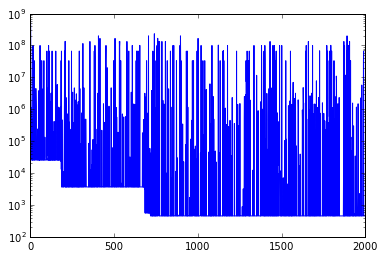

In [38]:
plt.plot(data)
plt.yscale('log')
print p
#plt.xlim(800,1000)
#plt.ylim(1000,2000)

In [298]:
x = population(10000,3,-1,2,3.6,0.02)
a = 0
b = []
for ind in x: 
    fitn = fitness(ind,obs_res, obs_unres, obs_res_err, obs_unres_err)
    #print np.isfinite(fitn)
    if (np.isfinite(fitn) == True): 
        #print fitn
        a += 1
        b.append(fitn)
print a
print max(b)

/Users/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jmartine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:74: RuntimeWarning: divide by zero encountered in log10


10000
661518240.516


In [68]:
g0 = np.array([[17052, 2, 19.284304196862681, 3.6, 3.6],[17619, 7, 2.4349283249092863, 3.6, 3.6],[6863, 2, 44.430107165223134, 3.6, 3.6]])
print g0[2,0], g0[2,1]

6863.0 2.0
